# Fractional VQE (package client)

This notebook solves a **long-only fractional portfolio allocation** using a **VQE-style** hybrid loop in PennyLane.

## Model

We target the mean–variance objective:

$$
\min_{w \in \Delta}\; -\mu^\top w + \lambda\, w^\top \Sigma w,
$$

where:
- $\mu$ is the expected return vector
- $\Sigma$ is the covariance matrix
- $\lambda \ge 0$ controls risk aversion
- $\Delta=\{w\ge0,\sum_i w_i=1\}$ is the simplex.

## Parameterization

We enforce simplex feasibility by construction:
1) Prepare an $n$-qubit circuit with angles $\theta$
2) Measure $z_i(\theta)=\langle Z_i\rangle$
3) Map to scores $s_i=(1-z_i)/2\in[0,1]$
4) Normalize $w_i=s_i/\sum_j s_j$

## Outputs
- Convergence (cost vs iteration)
- Allocation (bar + pie)
- $\lambda$-sweep allocations
- Efficient frontier $(\sigma, R)$ from sweep points

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import draw_mpl

from vqe_portfolio.ansatz import fractional_ry_layer
from vqe_portfolio.fractional import run_fractional_vqe, fractional_lambda_sweep
from vqe_portfolio.frontier import fractional_frontier_from_allocs
from vqe_portfolio.plotting import (
    plot_trace,
    bar_allocations,
    plot_lambda_sweep_bars,
    plot_frontier,
    savefig,
)
from vqe_portfolio.types import FractionalVQEConfig, LambdaSweepConfig
from vqe_portfolio.utils import set_global_seed, resolve_notebook_outdir

OUTDIR = resolve_notebook_outdir()

SEED = 0
set_global_seed(SEED)


## Toy data

In [2]:
mu = np.array([0.10, 0.20, 0.15, 0.12], dtype=float)

Sigma = np.array(
    [
        [0.005, -0.010, 0.004, -0.002],
        [-0.010, 0.040, -0.002, 0.004],
        [0.004, -0.002, 0.023, 0.002],
        [-0.002, 0.004, 0.002, 0.018],
    ],
    dtype=float,
)

n_assets = len(mu)

# Risk aversion
LAM = 5.0

# VQE hyperparameters
STEPS = 75
STEPSIZE = 0.3
LOG_EVERY = 5
SHOTS = None  # None -> exact expectations (statevector)

asset_labels = [f"Asset {i+1}" for i in range(n_assets)]

## Circuit preview (drawn via the shared ansatz)

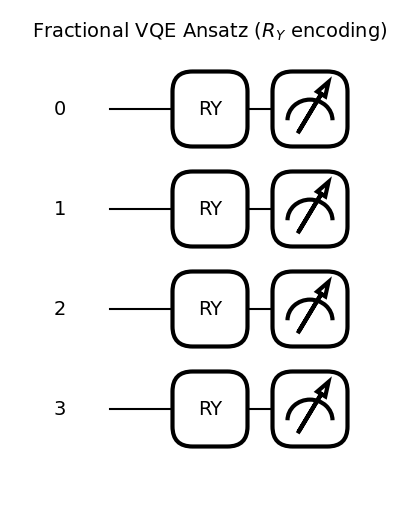

In [3]:
dev_preview = qml.device("default.qubit", wires=n_assets, shots=None)


@qml.qnode(dev_preview, interface="autograd")
def circuit_preview(thetas: np.ndarray):
    fractional_ry_layer(thetas, n_wires=n_assets)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]


demo_thetas = np.linspace(0.0, np.pi, n_assets)
fig, ax = draw_mpl(circuit_preview)(demo_thetas)
fig.suptitle(r"Fractional VQE Ansatz ($R_Y$ encoding)", fontsize=14)
savefig(OUTDIR / "Fractional_VQE_Circuit.png", dpi=300)
plt.show()

## Run Fractional VQE (package entry point)

In [4]:
cfg = FractionalVQEConfig(
    steps=STEPS,
    stepsize=STEPSIZE,
    log_every=LOG_EVERY,
    lam=LAM,
    device="default.qubit",
    shots=SHOTS,
    seed=SEED,
)

res = run_fractional_vqe(mu, Sigma, cfg)

w_opt = np.array(res.weights, dtype=float)
w_opt = w_opt / (w_opt.sum() + 1e-12)  # defensive

### Convergence plot

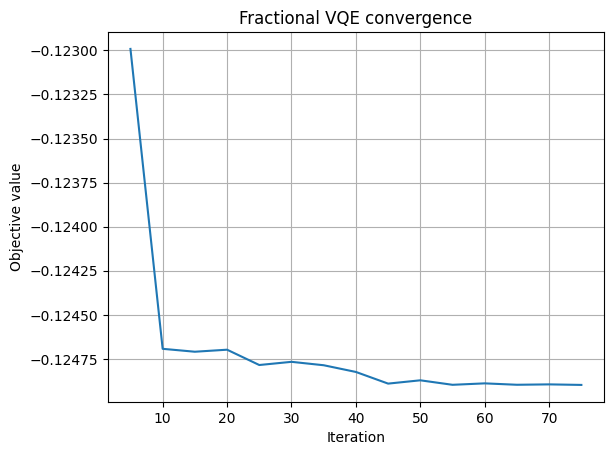

In [5]:
plot_trace(
    res.cost_trace.steps,
    res.cost_trace.values,
    xlabel="Iteration",
    ylabel="Objective value",
    title="Fractional VQE convergence",
    outpath=OUTDIR / "Fractional_VQE_Convergence.png",
)
plt.show()

## Results

In [6]:
print("\nOptimized allocation")
for i, w in enumerate(w_opt):
    print(f"Asset {i+1}: {float(w) * 100:.2f}%")

# Frontier utilities also compute (σ, R), but we print single-point metrics here for clarity.
R = float(mu @ w_opt)
sigma = float(np.sqrt(w_opt @ Sigma @ w_opt))
print(f"\nPortfolio return: {R:.6f}")
print(f"Portfolio risk  : {sigma:.6f}")


Optimized allocation
Asset 1: 48.19%
Asset 2: 35.64%
Asset 3: 13.06%
Asset 4: 3.11%

Portfolio return: 0.142792
Portfolio risk  : 0.059825


### Allocation bar chart

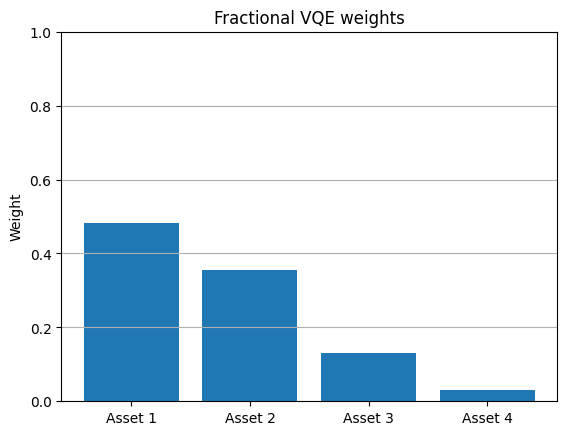

In [7]:
bar_allocations(
    labels=asset_labels,
    values=w_opt,
    ylabel="Weight",
    title="Fractional VQE weights",
    ylim=(0, 1),
    outpath=OUTDIR / "Fractional_VQE_Probabilities.png",
)
plt.show()

### Allocation pie chart

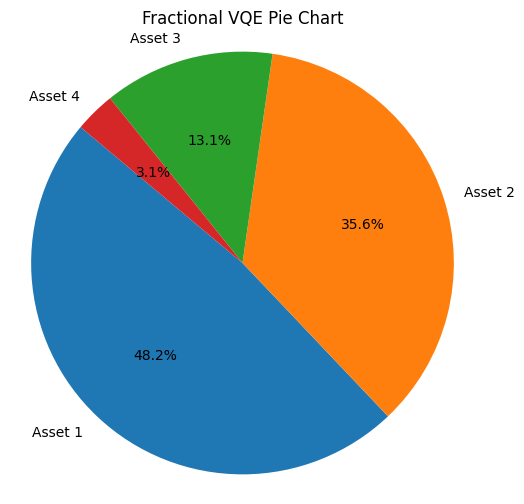

In [8]:
plt.figure(figsize=(6, 6))
plt.pie(
    w_opt,
    labels=asset_labels,
    autopct="%1.1f%%",
    startangle=140,
)
plt.title("Fractional VQE Pie Chart")
plt.axis("equal")
savefig(OUTDIR / "Fractional_VQE_Pie.png", dpi=300)
plt.show()

## λ sweep

In [9]:
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)

sweep_cfg = LambdaSweepConfig(
    lambdas=lambdas,
    steps_per_lambda=60,
    stepsize=0.2,
    warm_start=True,
)

res_sweep = fractional_lambda_sweep(mu, Sigma, cfg, sweep_cfg)

allocs = np.array(res_sweep.allocs_by_lambda, dtype=float)  # (L, n)
lam_arr = np.array(res_sweep.lambdas, dtype=float)

### λ sweep allocations

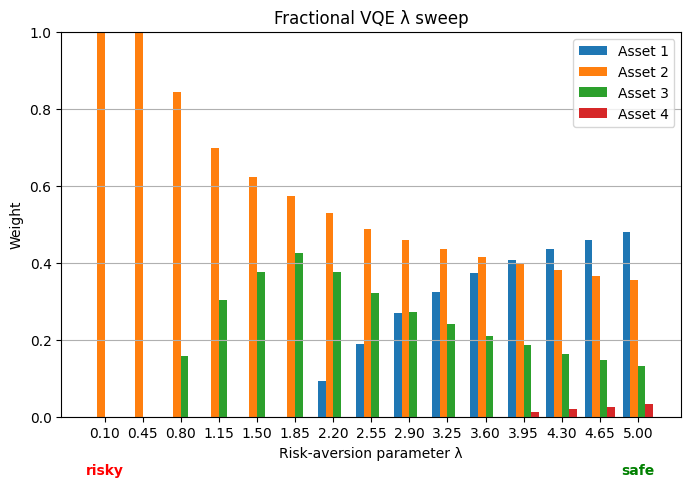

In [10]:
plot_lambda_sweep_bars(
    lambdas=lam_arr,
    mat=allocs,
    asset_labels=asset_labels,
    ylabel="Weight",
    title="Fractional VQE λ sweep",
    outpath=OUTDIR / "Fractional_VQE_Lambda_Sweep.png",
)
plt.show()

## Efficient frontier from λ sweep

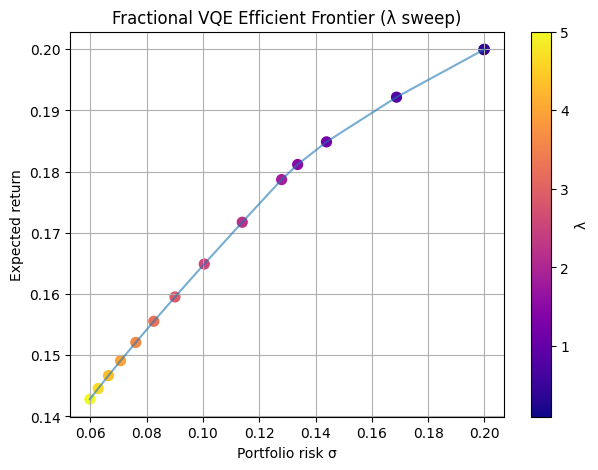

In [11]:
front = fractional_frontier_from_allocs(
    mu=mu,
    Sigma=Sigma,
    lambdas=lam_arr,
    allocs_by_lambda=allocs,
    renormalize=True,
    sort_by="risk",
)

plot_frontier(
    risks=front.risks,
    returns=front.returns,
    lambdas_sorted=front.lambdas,
    title="Fractional VQE Efficient Frontier (λ sweep)",
    outpath=OUTDIR / "Fractional_VQE_Efficient_Frontier.png",
)
plt.show()